In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from scipy.spatial import distance
from skimage.filters import gaussian
from skimage.filters import threshold_otsu
from skimage.morphology import binary_erosion
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage.draw import disk

In [2]:
def plot(image: np.ndarray, title=None, zlimit=True, **kwargs) -> None:
    fig, ax = plt.subplots(figsize=(8, 8))
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

[Sat, 01 Apr 2023 18:12:08] [INFO    ] [topostats] Extracting image from flat\20230126_KPN005.0_00013.spm
[Sat, 01 Apr 2023 18:12:08] [INFO    ] [topostats] Loading image from : flat\20230126_KPN005.0_00013.spm
[Sat, 01 Apr 2023 18:12:09] [INFO    ] [topostats] [20230126_KPN005.0_00013] : Loaded image from : flat\20230126_KPN005.0_00013.spm
[Sat, 01 Apr 2023 18:12:10] [INFO    ] [topostats] [20230126_KPN005.0_00013] : Extracted channel Height
[Sat, 01 Apr 2023 18:12:10] [INFO    ] [topostats] [20230126_KPN005.0_00013] : Pixel to nm scaling : 5.1109375


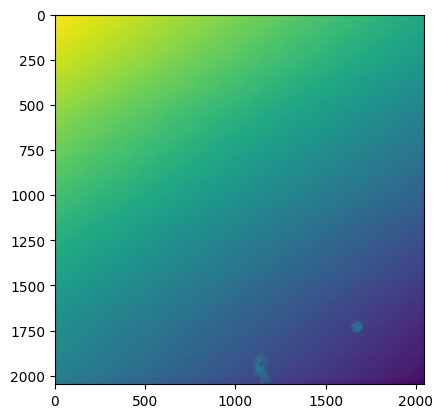

In [3]:
    #Flat
#file = Path('./Flat/20221213_KDNA001.0_00020.spm')
#file = Path('./flat/20230118_KPN001.0_00005.spm')
# file = Path('./Flat/20230118_KPN001.0_00011.spm')
#file = Path('./Flat/20230126_KPN005.0_00004.spm')
# file = Path('./flat/20230118_KPN001.0_00023.spm')
#file = Path('./flat/20230125_KPN005.0_00006.spm')
#file = Path('./flat/20230125_KPN005.0_00028.spm')
# file = Path('./flat/20230126_KPN005.0_00004.spm')
file = Path('./flat/20230126_KPN005.0_00013.spm')
# file = Path('./flat/20230126_KPN005.0_00019.spm')
# file = Path('./flat/20230126_KPN005.0_00024.spm')
# file = Path('./flat/20230217_KPN010.0_00010.spm')
# file = Path('./flat/20230314_KPN015.0_00016.spm')
    #Folded
# file = Path('./flat')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
plt.imshow(image_raw)

In [17]:
#Parameters
Rosette_Thres = 1.25
Gauss_Min_Size = 5
Gauss_Max_Size = 300
Gauss_Sigma = 20
Gauss_Thres = 0.003
Fibril_Min_Size = 30
Fibril_Max_Size = 300
Threshold_Dist = 0.1

In [15]:
filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 1.0, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

[Sat, 01 Apr 2023 18:17:32] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : Median flattening without mask
[Sat, 01 Apr 2023 18:17:33] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : Plane tilt removal without mask
[Sat, 01 Apr 2023 18:17:35] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : x-polyfit 1st order: [-2.95118672e-02  3.00639774e+01]
[Sat, 01 Apr 2023 18:17:35] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : y-polyfit 1st order: [ 1.07143464e-19 -9.32898823e-17]
[Sat, 01 Apr 2023 18:17:35] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : Removing x plane tilt
[Sat, 01 Apr 2023 18:17:39] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : removing y plane tilt
[Sat, 01 Apr 2023 18:17:44] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : Remove quadratic bow without mask
[Sat, 01 Apr 2023 18:17:44] [INFO    ] [topostats] [flat\20230126_KPN005.0_00013.spm] : x polyfit 2nd order: [-1.67071500e-07  3.4199

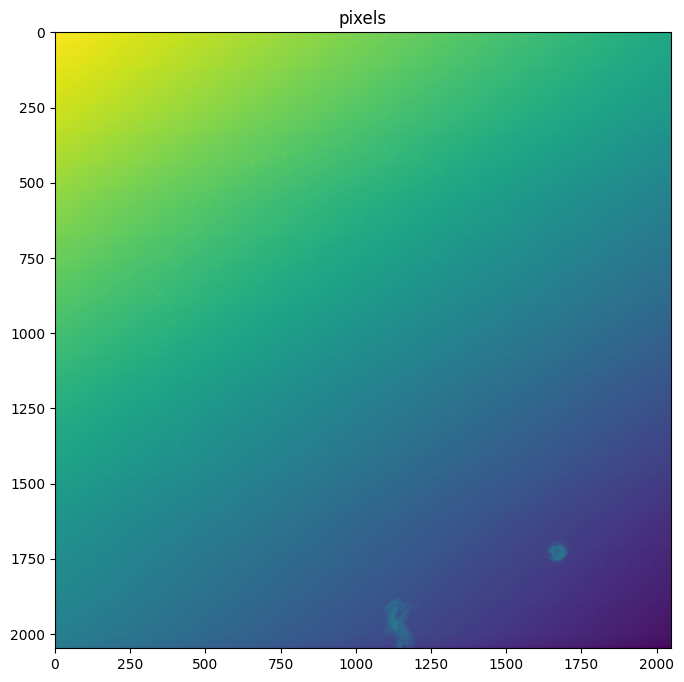

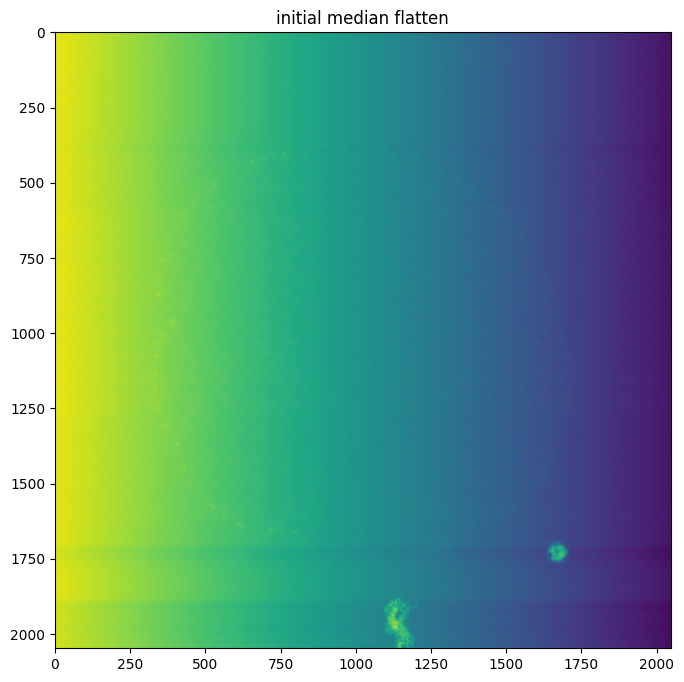

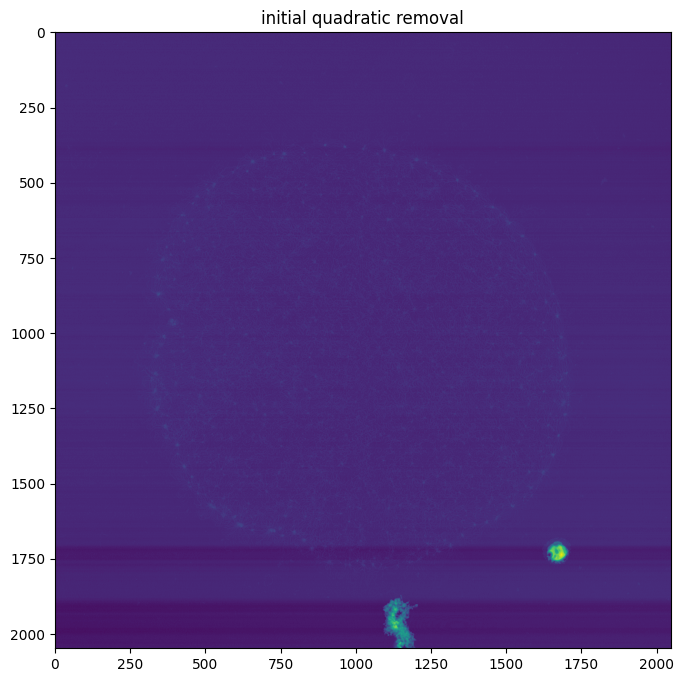

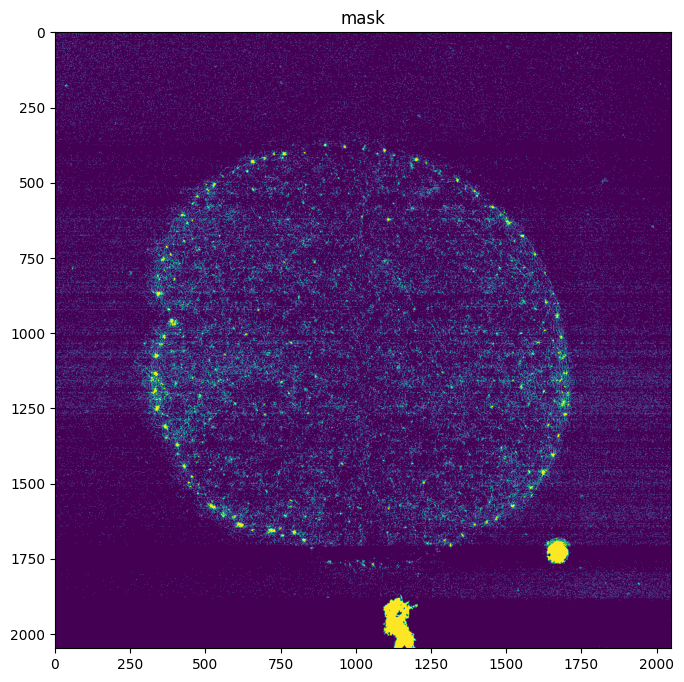

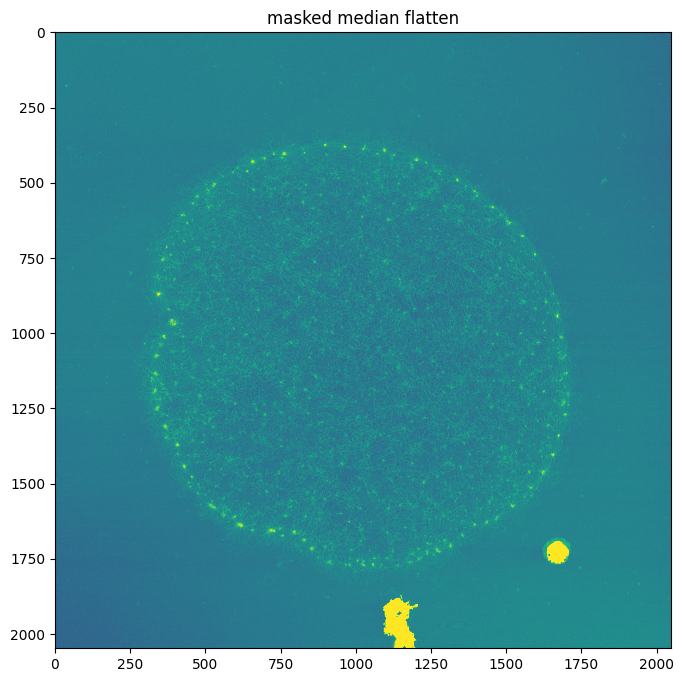

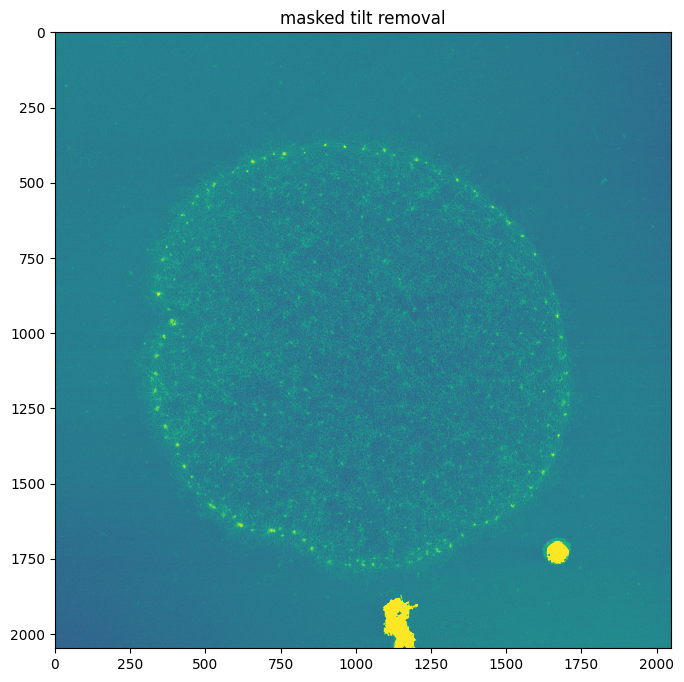

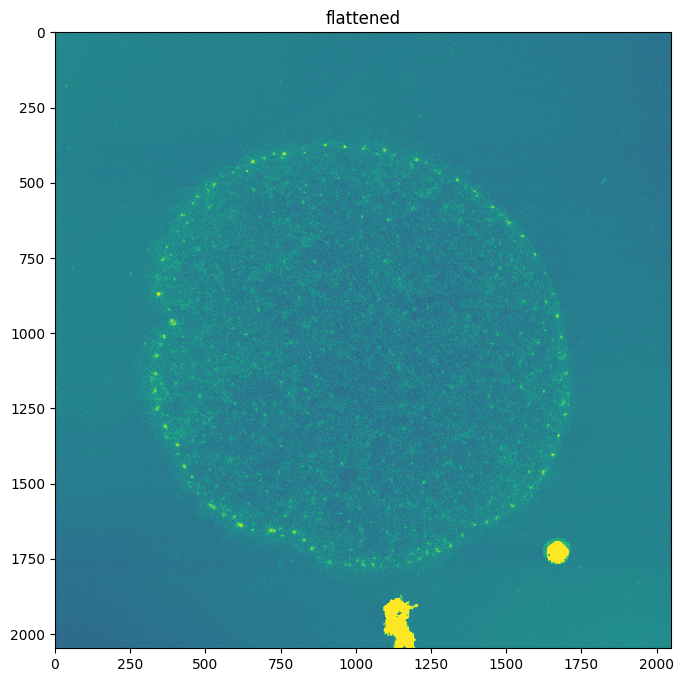

In [7]:
plot(filters.images['pixels'], title='pixels', zlimit=False)
plot(filters.images['initial_median_flatten'], zlimit=False, title='initial median flatten')
plot(filters.images['initial_quadratic_removal'], zlimit=False, title='initial quadratic removal')
plot(filters.images['mask'], title='mask', zlimit=False)
plot(filters.images['masked_median_flatten'], title='masked median flatten')
plot(filters.images['masked_tilt_removal'], title='masked tilt removal')

if np.array_equal(filters.images['masked_tilt_removal'], filters.images['masked_median_flatten']):
    print("EQUAL")

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened')

thresholds: defaultdict(None, {'upper': 1.5482072962198687})
[Sat, 01 Apr 2023 18:18:08] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 1.5482072962198687


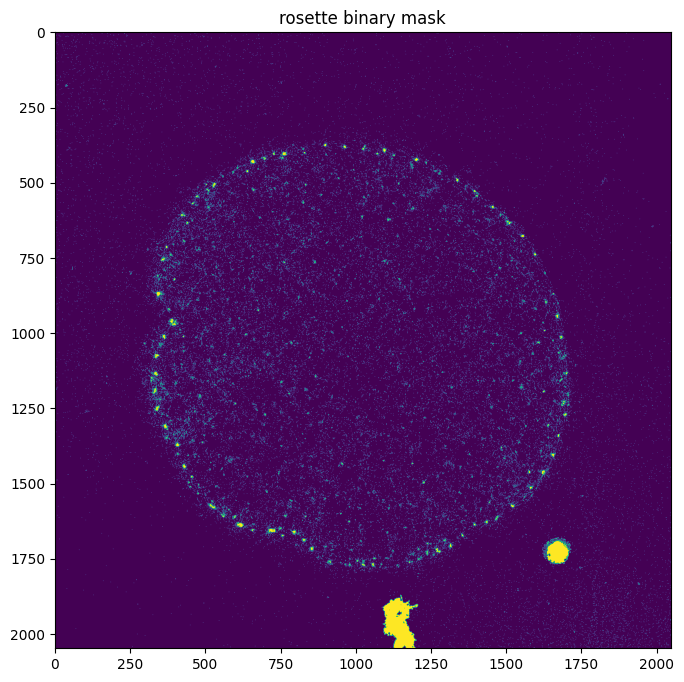

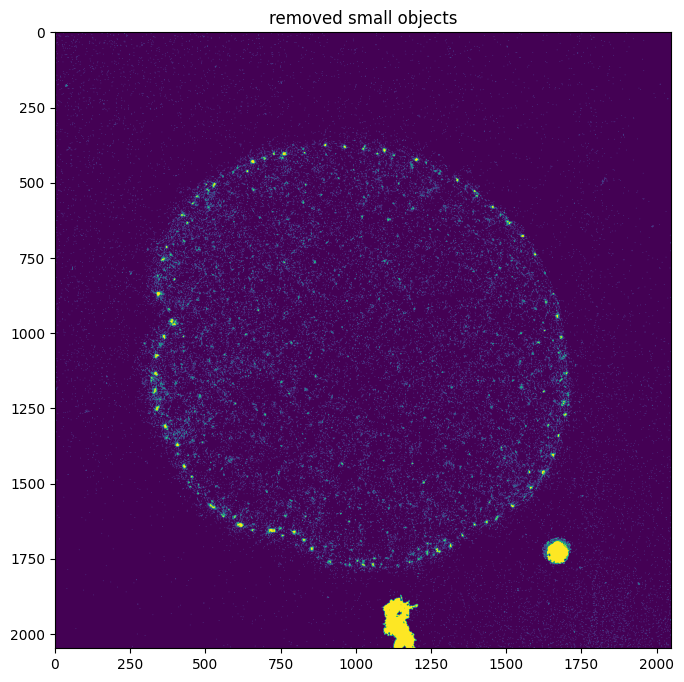

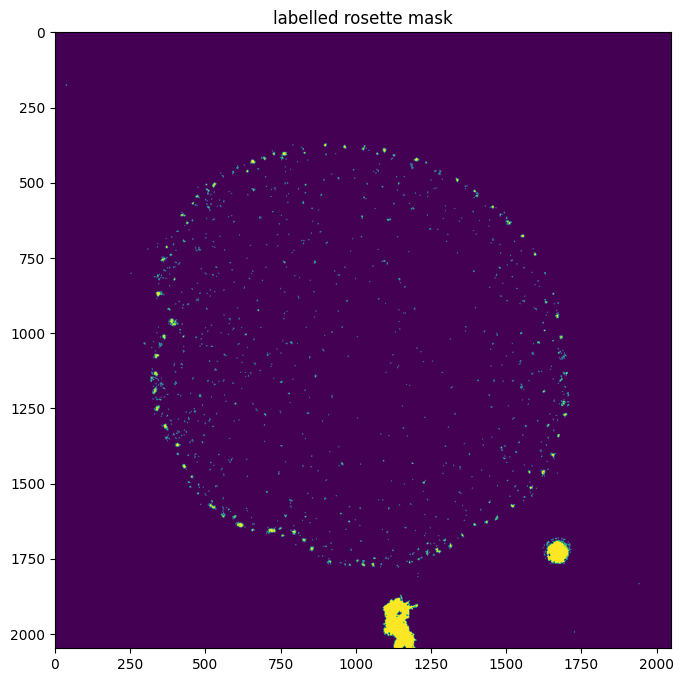

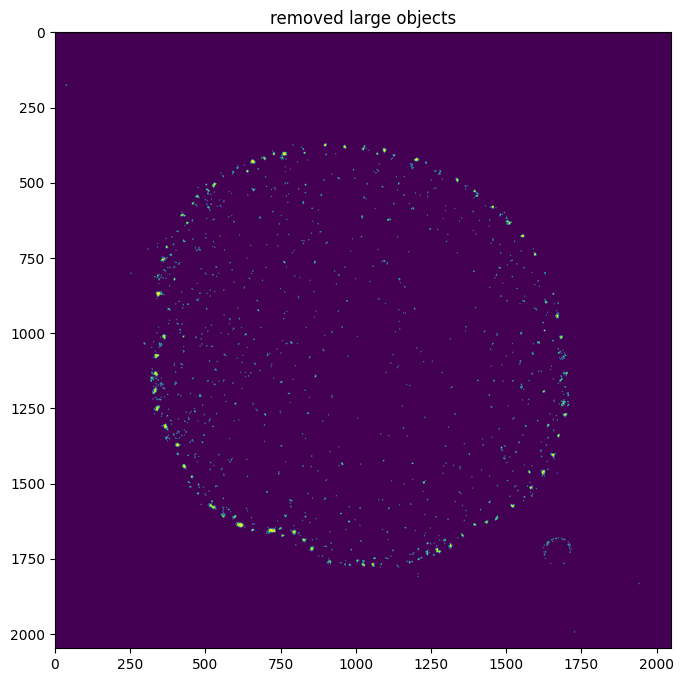

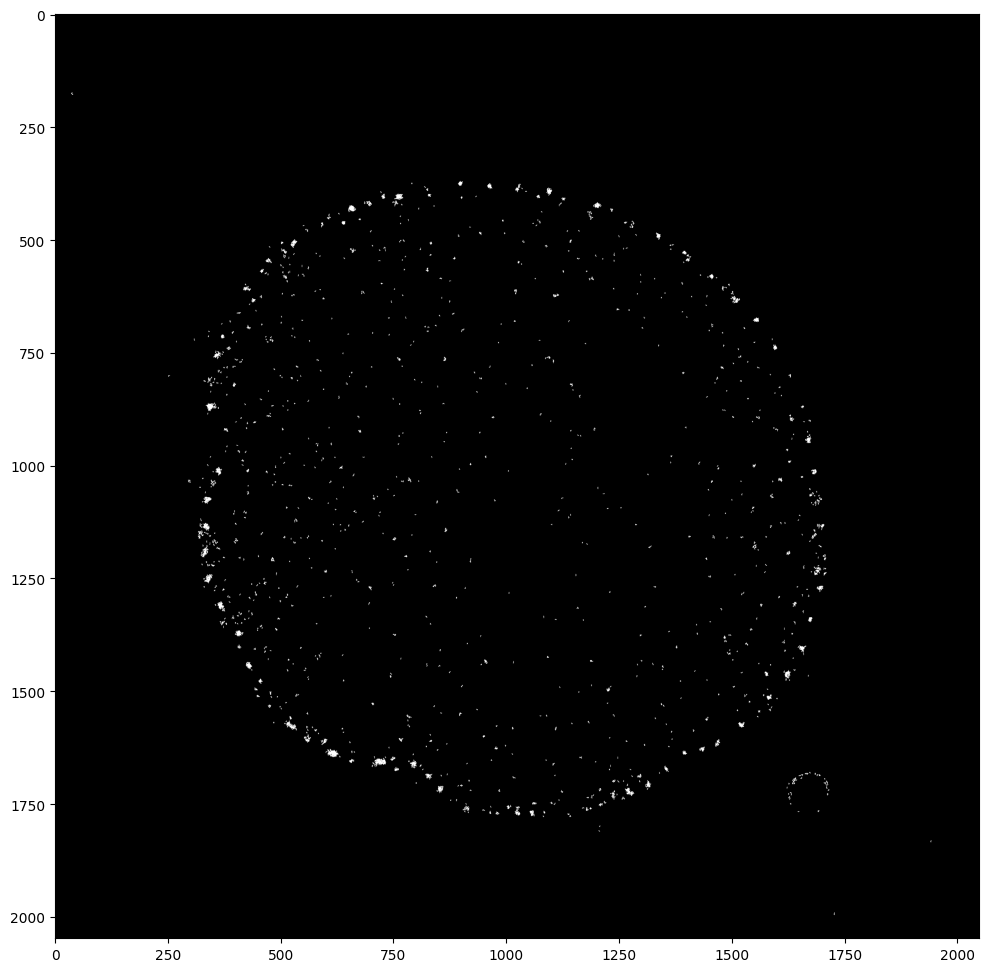

In [16]:
from skimage.morphology import remove_small_objects, label
from skimage.measure import regionprops
rosette_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': Rosette_Thres, 'lower': None}
)

print(f'thresholds: {rosette_thresholds}')
rosette_mask = topofilters.get_mask(image=flattened, thresholds=rosette_thresholds)
plot(rosette_mask.astype(bool), title='rosette binary mask', zlimit=False)

# Remove small objects
removed_small_objects = remove_small_objects(rosette_mask, Gauss_Min_Size)
plot(rosette_mask.astype(bool), title='removed small objects', zlimit=False)
# Remove large objects
labelled_rosette_mask = label(removed_small_objects)
plot(labelled_rosette_mask.astype(bool), title='labelled rosette mask', zlimit=False)
regions = regionprops(labelled_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Gauss_Max_Size:
        labelled_rosette_mask[labelled_rosette_mask==props.label] = 0

plot(labelled_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(labelled_rosette_mask.astype(bool), cmap='gray')


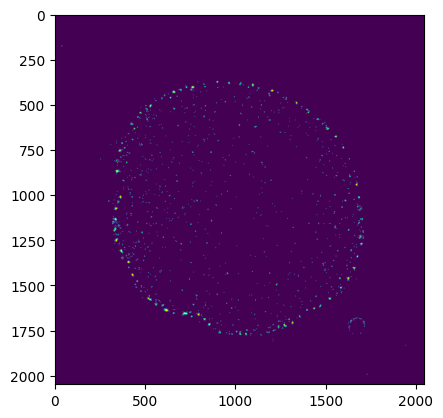

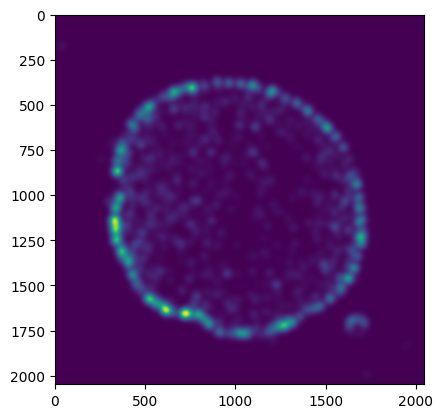

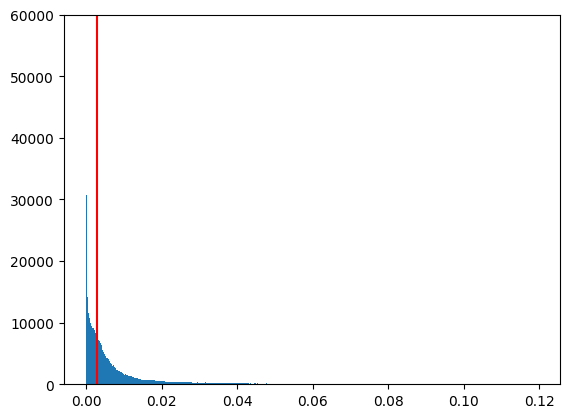

otsu threshold: 0.003


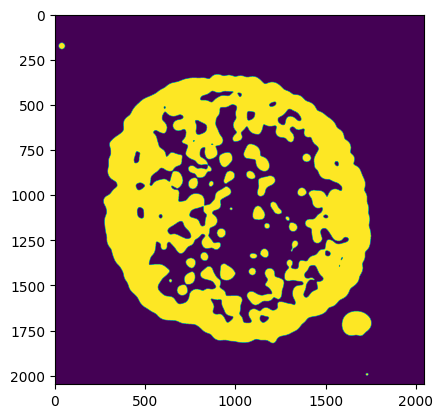

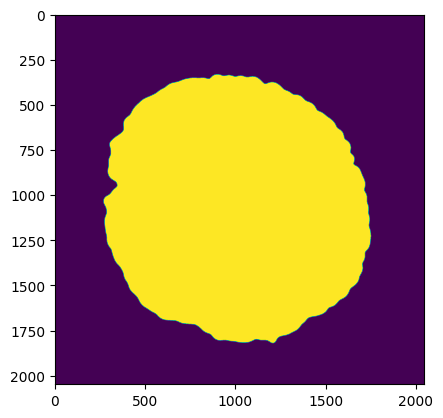

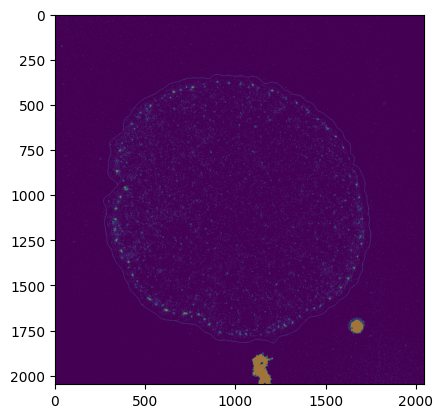

In [9]:
plt.imshow(labelled_rosette_mask.astype(bool))
plt.show()
gauss = gaussian(labelled_rosette_mask.astype(bool), Gauss_Sigma)
plt.imshow(gauss)
plt.show()



# threshold = threshold_otsu(gauss)
threshold = Gauss_Thres

fig, ax = plt.subplots()
ax.hist(gauss.flatten(), bins='auto')
ax.set_ylim(0, 60000)
plt.axvline(x=threshold, color='r')
plt.show()

print(f'otsu threshold: {threshold}')
thresholded = gauss > threshold
plt.imshow(thresholded)
plt.show()

labelled = label(thresholded)
region_props = regionprops(labelled)
max_size = max([props.area for props in region_props])
thresholded = remove_small_objects(thresholded, min_size=max_size-1)
thresholded = ndimage.binary_fill_holes(thresholded)
plt.imshow(thresholded)
plt.show()

# Add padding (needed for erosion)
padded = np.pad(thresholded, 1)
# Erode by 1 pixel
eroded = binary_erosion(padded)
# Remove padding
eroded = eroded[1:-1, 1:-1]

# Edges is equal to the difference between the
# original image and the eroded image.
edges = thresholded.astype(int) - eroded.astype(int)
plt.imshow(rosette_mask)
plt.imshow(edges, alpha=0.5)
plt.show()

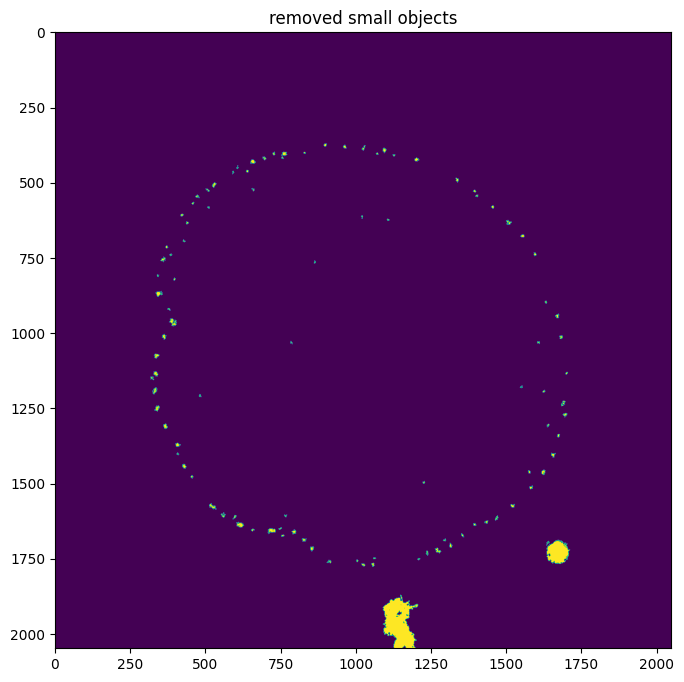

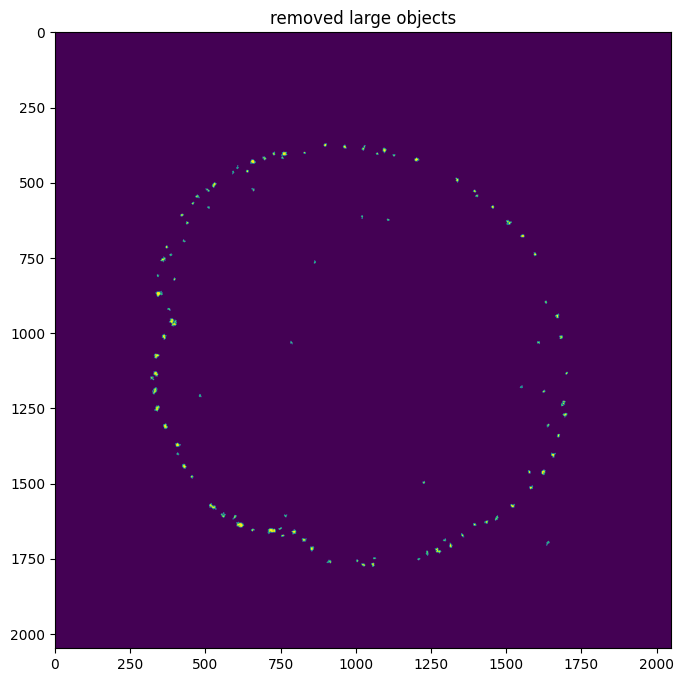

In [18]:
#Second Thresholding
fibril_thres = rosette_mask.copy()
# Remove small objects
fib_removed_small_objects = remove_small_objects(fibril_thres, Fibril_Min_Size)
plot(fib_removed_small_objects.astype(bool), title='removed small objects', zlimit=False)
#Remove large objects
fibril_rosette_mask = label(fib_removed_small_objects)
#plot(fibril_rosette_mask.astype(bool), title='fibril rosette mask', zlimit=False)
regions = regionprops(fibril_rosette_mask)
for props_index, props in enumerate(regions):
    if props.area > Fibril_Max_Size:
        fibril_rosette_mask[fibril_rosette_mask==props.label] = 0

plot(fibril_rosette_mask.astype(bool), title='removed large objects', zlimit=False)
plt.show()


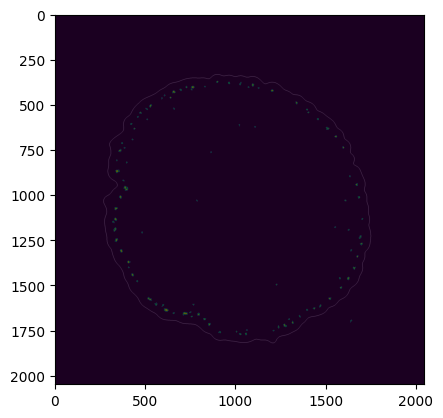

mean distance: 70.99112929119958
std dev distance: 66.57324140254522


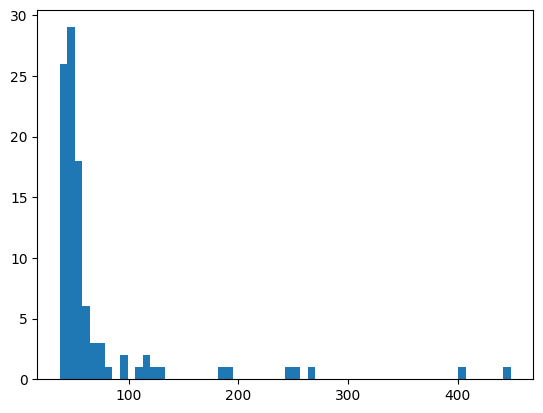

distance threshold: 64.33380515094507
points shape: (78, 2)


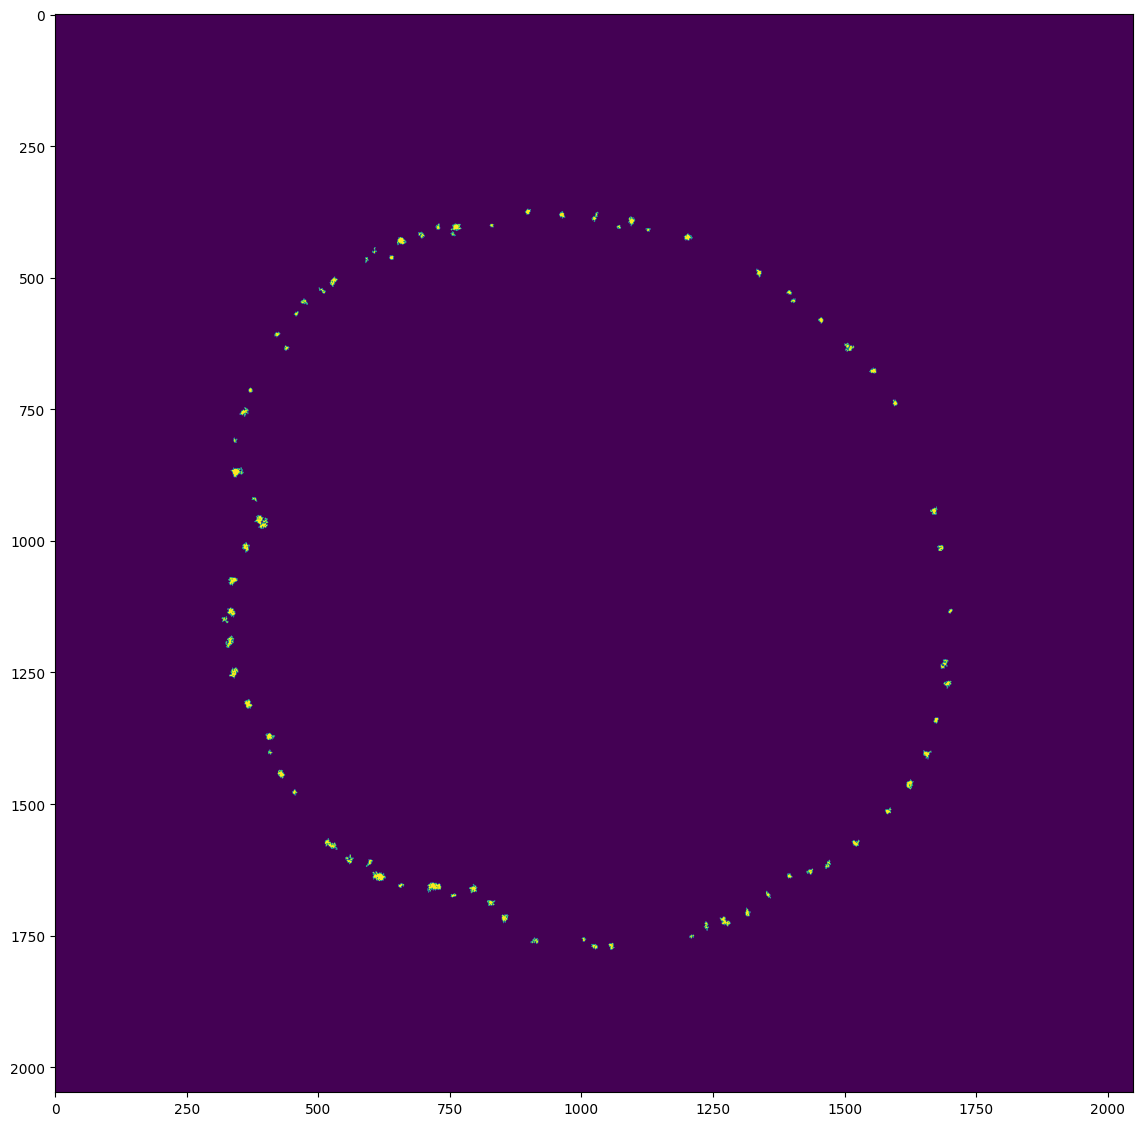

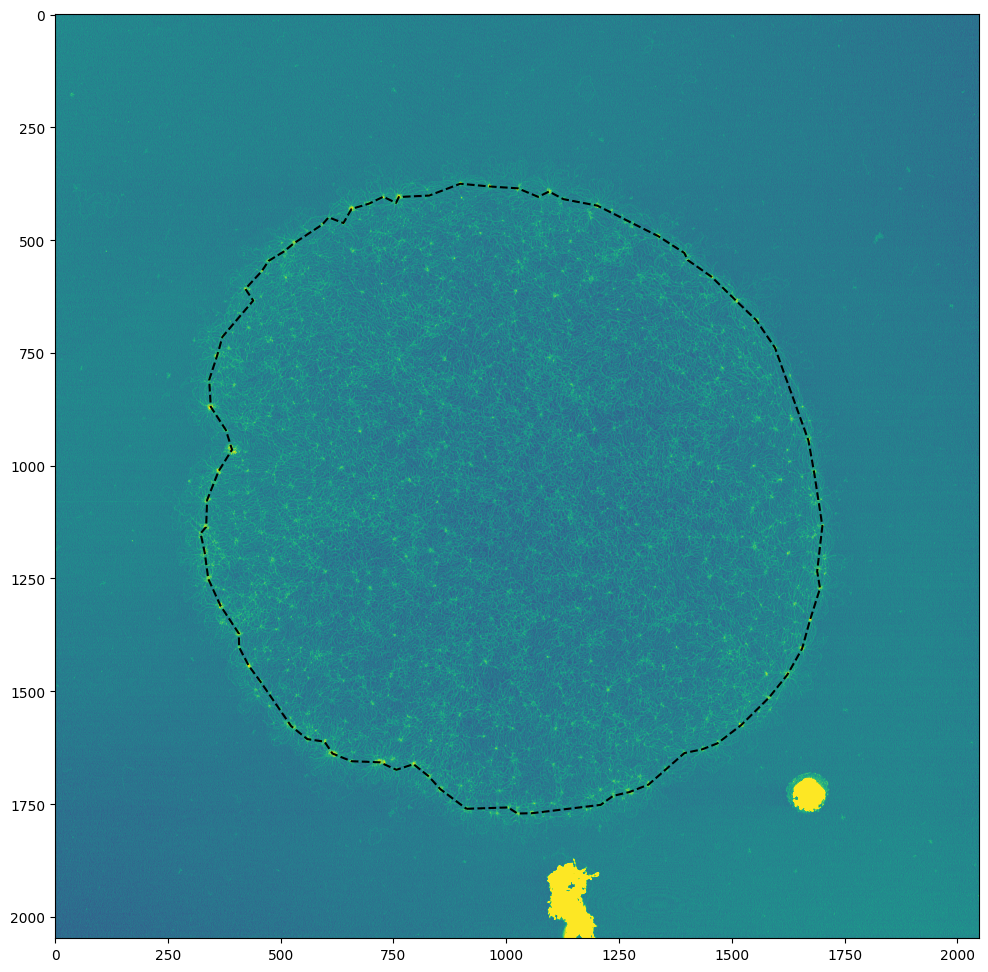

In [21]:
plt.imshow(fibril_rosette_mask.astype(bool))
plt.imshow(edges, alpha=0.6, cmap='gray')
plt.show()

edge_positions = np.transpose(np.nonzero(edges))
region_props = regionprops(fibril_rosette_mask)
min_distances = np.zeros(len(region_props))
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    min_distances[props_index] = min_distance

print(f'mean distance: {np.mean(min_distances)}')
print(f'std dev distance: {np.std(min_distances)}')
plt.hist(min_distances, bins='auto')
plt.show()
distance_threshold = np.mean(min_distances) - Threshold_Dist * np.std(min_distances)
print(f'distance threshold: {distance_threshold}')

removed_too_far_points = fibril_rosette_mask.copy()
points = np.array([])
for props_index, props in enumerate(region_props):
    proplabel = props['label']
    centroid = np.array(props['centroid']).reshape(-1, 2)
    distances = np.linalg.norm(centroid - edge_positions, axis=1)
    min_distance = np.min(distances)
    if min_distance > distance_threshold:
        removed_too_far_points[removed_too_far_points == proplabel] = 0
    else:
        points = np.append(points, centroid).reshape(-1, 2)

points = np.array(points)
print(f'points shape: {points.shape}')

fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(removed_too_far_points.astype(bool))
plt.show()

# Find centroids of remaining points
labelled = label(removed_too_far_points)
regions = regionprops(labelled)
points = np.ndarray((len(regions), 2))
for props_index, props in enumerate(regions):
    points[props_index, :] = props.centroid

centroid = np.array([np.mean(points[:, 0]), np.mean(points[:, 1])])

# Function to find angle of point from centroid
def angle(point, centroid):
    dx, dy = point - centroid
    return (np.arctan2(dy, dx) + 2 * np.pi) % (2 * np.pi)

# Sort the points based on their angles around the centroid
sorted = points[np.argsort([angle(point, centroid) for point in points])]

xs = np.append(sorted[:, 1], sorted[0, 1])
ys = np.append(sorted[:, 0], sorted[0, 0])

fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(flattened, vmin=-3, vmax=4)
ax.plot(xs, ys, 'k--')

plt.show()


In [22]:
def draw_line(img, p1, p2):
    img = img.copy()
    x1, y1 = p1
    x2, y2 = p2
    # Swap axes if y diff is smaller than x diff
    swap = abs(x2 - x1) < abs(y2 - y1)
    if swap:
        img = img.T
        x1, y1, x2, y2 = y1, x1, y2, x2
    # Swap line direction if x2 < x1
    if x2 < x1:
        x1, y1, x2, y2 = x2, y2, x1, y1
    # Draw line endpoints
    img[x1, y1] = True
    img[x2, y2] = True
    # Find intermediary points
    x = np.arange(x1 + 1, x2)
    y = np.round(((y2 - y1) / (x2 - x1)) * (x - x1) + y1).astype(int)
    # Write intermediary points
    img[x, y] = True
    
    return img if not swap else img.T

def create_near_outline_mask(image_shape: tuple, nodes: np.ndarray, gaussian_sigma: int):

    line_mask = np.zeros(image_shape)
    for index in range(len(nodes)-1):
        p1 = nodes[index, :]
        p1 = np.round(p1).astype(int)
        p2 = nodes[index+1, :]
        p2 = np.round(p2).astype(int)
        line_mask = draw_line(line_mask, p1, p2)

    blurred_line_mask = gaussian(line_mask, sigma=gaussian_sigma)
    
    return line_mask, blurred_line_mask


def draw_line_locus(img, p1, p2, locus):
    
    max_i = img.shape[1] - 1
    max_j = img.shape[0] - 1

    x1, y1 = p1
    x2, y2 = p2
    # Swap axes if y diff is smaller than x diff
    swap = abs(x2 - x1) < abs(y2 - y1)
    if swap:
        img = img.T
        x1, y1, x2, y2 = y1, x1, y2, x2
    # Swap line direction if x2 < x1
    if x2 < x1:
        x1, y1, x2, y2 = x2, y2, x1, y1
    # # Draw line endpoints
    # img[x1, y1] = True
    # img[x2, y2] = True
    # # Find intermediary points
    # x = np.arange(x1 + 1, x2)
    # y = np.round(((y2 - y1) / (x2 - x1)) * (x - x1) + y1).astype(int)

    m = (y2 - y1) / (x2 - x1)
    c = y1 - m * x1

    if x1 > x2:
        rangei = range(x2 - locus, x1 + locus + 1)
    else:
        rangei = range(x1 - locus, x2 + locus + 1)
    if y1 > y2:
        rangej = range(y2 - locus, y1 + locus + 1)
    else:
        rangej = range(y1 - locus, y2 + locus + 1)
    # print(list(rangei))
    # print(list(rangej))
    for j in rangej:
        for i in rangei:
            # print(f': {i, j}')
            if i > 0 and j > 0 and i <= max_i and j <= max_j:
                dist = abs(m * i - j + c) / np.sqrt(m**2 + 1)

                if dist <= locus:
                    img[i, j] = 1

    img[x1, y1] = 2
    img[x2, y2] = 2
        
    return img if not swap else img.T

def locus_outline(image_shape: tuple, nodes: np.ndarray, locus: int):

    mask = np.zeros(image_shape)

    for index in range(len(nodes)-1):
        p1 = nodes[index, :]
        p1 = np.round(p1).astype(int)
        p2 = nodes[index+1, :]
        p2 = np.round(p2).astype(int)

        mask = draw_line_locus(mask, p1, p2, locus)

    return mask

# mask = locus_outline(flattened.shape, sorted_loop, 10)
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.imshow(mask)

def distance_to_outline(outline_mask, point):
    nonzero = np.argwhere(outline_mask == True)
    # print(point)
    # print(nonzero)
    diffs = nonzero - point
    # print(diffs)
    dists_squared = diffs[:, 0]**2 + diffs[:, 1]**2
    # print(dists_squared)
    # smallest_dist_squared = np.argmin(dists_squared)
    # print(smallest_dist_squared)
    # print(nonzero[smallest_dist_squared])
    return np.min(dists_squared)

line_mask, _ = create_near_outline_mask(flattened.shape, sorted_loop, 1)

point = np.array([np.random.randint(0, flattened.shape[0]), np.random.randint(0, flattened.shape[1])])
# closest_point = distance_to_outline(line_mask, point)

print(distance_to_outline(line_mask, point))

# line_mask = draw_line(line_mask, closest_point, point)
# line_mask[point[0], point[1]] = 2
# fig, ax = plt.subplots(figsize=(10, 10))
# plt.imshow(line_mask.astype(bool))


61141


In [20]:
def point_in_polygon(point: np.ndarray, polygon: np.ndarray):
    count = 0
    x = point[0]
    y = point[1]

    for index in range(polygon.shape[0] - 1):
        x1, y1 = polygon[index, :]
        x2, y2 = polygon[index + 1, :]

        if (y < y1) != (y < y2):
            # if x is to the left of the intersection point.
            # x - x1 < (y - y1) / m
            # intersection's x-coord is x1 plus the difference of the point and
            # p1's y coord, divided by the gradient.
            if x < (x2 - x1) * (y - y1) / (y2 - y1) + x1:
                count += 1
    if count % 2 == 0:
        return False
    else:
        return True


In [44]:
def network_density_internal(nodes: np.ndarray, image: np.ndarray, px_to_nm: float, stepsize_px: int, kernel_size: int, gaussian_sigma: int):
    # fig, ax = plt.subplots()
    # ax.imshow(image)
    density_map = np.zeros((int(np.floor(image.shape[0] / stepsize_px)), int(np.floor(image.shape[1] / stepsize_px))))
    internal_density_map = np.zeros(density_map.shape)
    near_outline_density_map = np.zeros(density_map.shape)
    densities_internal = []
    distances_internal = []
    densities_near_outline = []
    distances_near_outline = []

    print(f'density map dimensions: {internal_density_map.shape}')

    outline_mask, near_outline_mask = create_near_outline_mask(image.shape, nodes, gaussian_sigma)

    for j in range(internal_density_map.shape[0]):
        for i in range(internal_density_map.shape[1]):
            x = i * stepsize_px
            y = j * stepsize_px

            density = np.median(image[y-kernel_size:y+kernel_size, x-kernel_size:x+kernel_size])
            density_map[j, i] = density

            # volume = np.sum(image[y-kernel_size:y+kernel_size, x-kernel_size:x+kernel_size])
            # density = volume / area
            # area = stepsize_px**2 * px_to_nm**2

            in_polygon = point_in_polygon(np.array([y, x]), nodes)
            if near_outline_mask[y, x]:
                near_outline = True
            else:
                near_outline = False

            # color = 'green' if in_polygon else 'red'
            # ax.plot(y, x, marker='.', color=color)
            if in_polygon and not near_outline:
                internal_density_map[j, i] = density
                densities_internal.append(density)
                distances_internal.append(distance_to_outline(outline_mask, np.array([y, x])))
            elif near_outline:
                densities_near_outline.append(density)
                distances_near_outline.append(distance_to_outline(outline_mask, np.array([y, x])))
                near_outline_density_map[j, i] = density

    # plt.plot(nodes[:, 1], nodes[:, 0], color='black')
    # plt.show()
    return density_map, internal_density_map, near_outline_density_map, densities_internal, distances_internal, densities_near_outline, distances_near_outline

sorted_loop = np.append(sorted, sorted[0, :]).reshape(-1, 2)
global_density, internal_density, near_outline_density, dens_internal, dist_internal, dens_noutline, dist_noutline = network_density_internal(
    nodes=sorted_loop,
    image=flattened,
    px_to_nm=p_to_nm,
    stepsize_px=50,
    kernel_size=50,
    gaussian_sigma=10
)



density map dimensions: (40, 40)


c:\Users\bdigg\miniconda3\envs\git_topo\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\bdigg\miniconda3\envs\git_topo\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


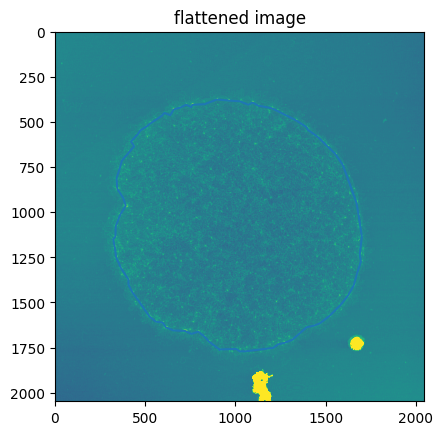

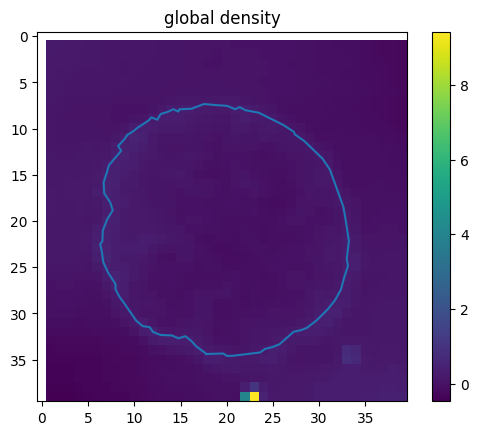

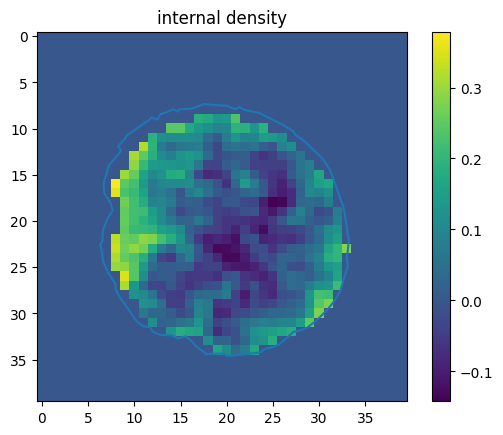

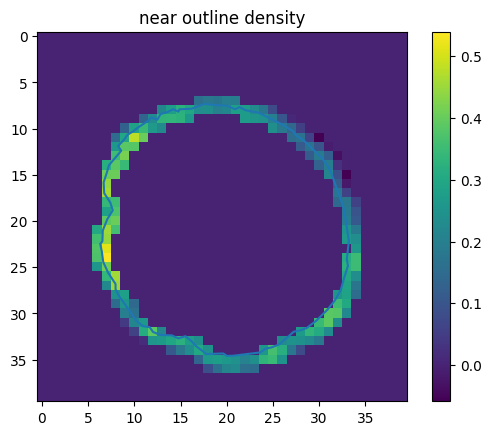

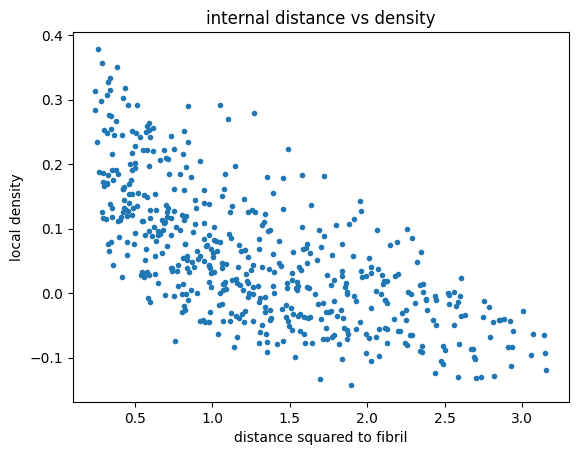

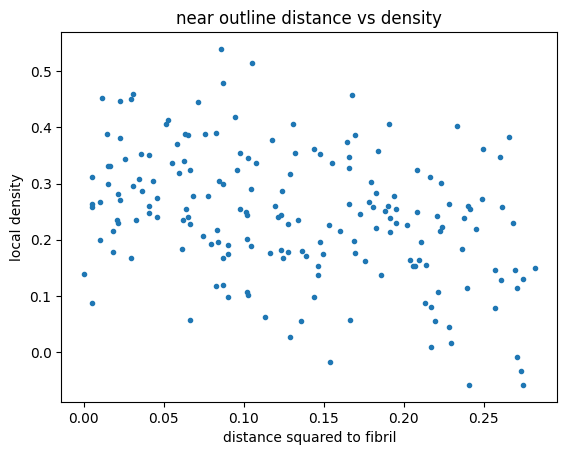

In [46]:
#Apply unit scaling
dist_internal = np.sqrt(dist_internal)*p_to_nm*0.001
dist_noutline = np.sqrt(dist_noutline)*p_to_nm*0.001



scaling_factor = flattened.shape[0] / internal_density.shape[0]
plt.imshow(flattened, vmin=-3, vmax=4)
plt.plot(sorted_loop[:, 1], sorted_loop[:, 0])
plt.title('flattened image')
plt.show()
plt.imshow(global_density)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('global density')
plt.show()
plt.imshow(internal_density)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('internal density')
plt.show()
plt.imshow(near_outline_density)
plt.plot(sorted_loop[:, 1] / scaling_factor, sorted_loop[:, 0] / scaling_factor)
plt.colorbar()
plt.title('near outline density')
plt.show()


plt.scatter(x=dist_internal, y=dens_internal, marker='.')
plt.xlabel('distance squared to fibril')
plt.ylabel('local density')
plt.title('internal distance vs density')
plt.show()
plt.scatter(x=dist_noutline, y=dens_noutline, marker='.')
plt.title('near outline distance vs density')
plt.xlabel('distance squared to fibril')
plt.ylabel('local density')
plt.show()

In [49]:
data = [dist_internal,dens_internal,dist_noutline,dens_noutline]

with open('density.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for stat in data: 
        writer.writerow(np.transpose(stat))

In [ ]:
def shoelace(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    area = 0
    for index in range(len(points)-1):
        matrix = points[index:index+2, :].T
        area += np.linalg.det(matrix)
    return np.round(area/2, 5)

In [ ]:
def point_distances(points: np.ndarray):
    distance_matrix = distance.cdist(points, points, 'euclidean')
    distances = distance_matrix[np.triu_indices(points.shape[0], k=1)]
    return np.round(distances, 5)

In [ ]:
def polygon_perimeter(points: np.ndarray):
    points = np.append(points, points[0]).reshape(-1, 2)
    perimeter = 0
    for i in range(len(points)-1):
        point1 = points[i, :]
        point2 = points[i+1, :]
        perimeter += np.sqrt((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)
    return perimeter

In [ ]:
def region_stats(labelled_image: np.ndarray, image: np.ndarray):

    region_props = regionprops(label_image=labelled_image)
    areas = np.zeros(len(region_props))
    volumes = np.zeros(len(region_props))
    max_heights = np.zeros(len(region_props))
    mean_heights = np.zeros(len(region_props))
    for props_index, props in enumerate(region_props):
        areas[props_index] = props.area
        region_points = np.where(labelled_image == props.label)
        region_values = image[region_points]
        volume = np.sum(region_values)
        volumes[props_index] = volume
        max_heights[props_index] = np.max(region_values)
        mean_heights[props_index] = np.mean(region_values)

    return {
        'areas': areas,
        'volumes': volumes,
        'max_heights': max_heights,
        'mean_heights': mean_heights,
        'number_of_regions': len(region_props),
    }

In [ ]:
def curvature(xs: np.ndarray, ys: np.ndarray):
    extension_length = xs.shape[0]
    xs_extended = np.append(xs, xs)
    xs_extended = np.append(xs_extended, xs)
    ys_extended = np.append(ys, ys)
    ys_extended = np.append(ys_extended, ys)
    dx = np.gradient(xs_extended)
    dy = np.gradient(ys_extended)
    d2x = np.gradient(dx)
    d2y = np.gradient(dy)
    curv = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5
    #curv = curv[extension_length:(len(curv)-extension_length)+1]
    return curv

In [ ]:
def is_clockwise(p_1: tuple, p_2: tuple, p_3: tuple) -> bool:
    """Function to determine if three points make a clockwise or counter-clockwise turn.

    Parameters
    ----------
    p_1: tuple
        First point to be used to calculate turn.
    p_2: tuple
        Second point to be used to calculate turn.
    p_3: tuple
        Third point to be used to calculate turn.

    Returns
    -------
    boolean
        Indicator of whether turn is clockwise.
    """

    rotation_matrix = np.array(((p_1[0], p_1[1], 1), (p_2[0], p_2[1], 1), (p_3[0], p_3[1], 1)))
    return not np.linalg.det(rotation_matrix) > 0

def get_triangle_height(base_point_1: np.array, base_point_2: np.array, top_point: np.array) -> float:
    """Returns the height of a triangle defined by the input point vectors.
    Parameters
    ----------
    base_point_1: np.ndarray
        a base point of the triangle, eg: [5, 3].

    base_point_2: np.ndarray
        a base point of the triangle, eg: [8, 3].

    top_point: np.ndarray
        the top point of the triangle, defining the height from the line between the two base points, eg: [6,10].

    Returns
    -------
    Float
        The height of the triangle - ie the shortest distance between the top point and the line between the two base points.
    """

    # Height of triangle = A/b = ||AB X AC|| / ||AB||
    a_b = base_point_1 - base_point_2
    a_c = base_point_1 - top_point
    return np.linalg.norm(np.cross(a_b, a_c)) / np.linalg.norm(a_b)

def ferets(edges: np.ndarray) -> float:
    """Returns the minimum and maximum feret diameters for a grain.
    These are defined as the smallest and greatest distances between
    a pair of callipers that are rotating around a 2d object, maintaining
    contact at all times.

    Parameters
    ----------
    edge_points: list
        a list of the vector positions of the pixels comprising the edge of the
        grain. Eg: [[0, 0], [1, 0], [2, 1]]
    Returns
    -------
    min_feret: float
        the minimum feret diameter of the grain
    max_feret: float
        the maximum feret diameter of the grain"""

    # Sort the vectors by x coordinate then y coordinate
    sorted_indices = np.lexsort((edges[:, 1], edges[:, 0]))
    sorted = edges[sorted_indices]

    # Construct upper and lower hulls for the edge points.
    upper_hull = []
    lower_hull = []
    for point in sorted:
        #print(point)
        while len(lower_hull) > 1 and is_clockwise(lower_hull[-2], lower_hull[-1], point):
            lower_hull.pop()
        lower_hull.append(point)
        while len(upper_hull) > 1 and not is_clockwise(upper_hull[-2], upper_hull[-1], point):
            upper_hull.pop()
        upper_hull.append(point)
    
    upper_hull = np.array(upper_hull)
    lower_hull = np.array(lower_hull)

    # Create list of contact vertices for calipers on the antipodal hulls
    contact_points = []
    upper_index = 0
    lower_index = len(lower_hull) - 1
    min_feret = None
    while upper_index < len(upper_hull) - 1 or lower_index > 0:
        contact_points.append([lower_hull[lower_index, :], upper_hull[upper_index, :]])
        # If we have reached the end of the upper hull, continute iterating over the lower hull
        if upper_index == len(upper_hull) - 1:
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # If we have reached the end of the lower hull, continue iterating over the upper hull
        elif lower_index == 0:
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        # Check if the gradient of the last point and the proposed next point in the upper hull is greater than the gradient
        # of the two corresponding points in the lower hull, if so, this means that the next point in the upper hull
        # will be encountered before the next point in the lower hull and vice versa.
        # Note that the calculation here for gradients is the simple delta upper_y / delta upper_x > delta lower_y / delta lower_x
        # however I have multiplied through the denominators such that there are no instances of division by zero. The
        # inequality still holds and provides what is needed.
        elif (upper_hull[upper_index + 1, 1] - upper_hull[upper_index, 1]) * (
            lower_hull[lower_index, 0] - lower_hull[lower_index - 1, 0]
        ) > (lower_hull[lower_index, 1] - lower_hull[lower_index - 1, 1]) * (
            upper_hull[upper_index + 1, 0] - upper_hull[upper_index, 0]
        ):
            # If the upper hull is encoutnered first, increment the iteration index for the upper hull
            # Also consider the triangle that is made as the two upper hull vertices are colinear with the caliper
            upper_index += 1
            small_feret = get_triangle_height(
                np.array(upper_hull[upper_index - 1, :]),
                np.array(upper_hull[upper_index, :]),
                np.array(lower_hull[lower_index, :]),
            )
            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret
        else:
            # The next point in the lower hull will be encountered first, so increment the lower hull iteration index.
            lower_index -= 1
            small_feret = get_triangle_height(
                np.array(lower_hull[lower_index + 1, :]),
                np.array(lower_hull[lower_index, :]),
                np.array(upper_hull[upper_index, :]),
            )

            if min_feret is None or small_feret < min_feret:
                min_feret = small_feret

    contact_points = np.array(contact_points)

    # Find the minimum and maximum distance in the contact points
    max_feret = None
    for point_pair in contact_points:
        dist = np.sqrt((point_pair[0, 0] - point_pair[1, 0]) ** 2 + (point_pair[0, 1] - point_pair[1, 1]) ** 2)
        if max_feret is None or max_feret < dist:
            max_feret = dist

    return min_feret, max_feret

In [ ]:

MICRON_SCALING_FACTOR = 0.001
P_TO_MICRON = p_to_nm * MICRON_SCALING_FACTOR

print('Image:',file)

print('- molecule stats -')
area = shoelace(sorted)* P_TO_MICRON**2
print(f'area: {area:.2f} μm^2')
perimeter = polygon_perimeter(sorted)* P_TO_MICRON
print(f'perimeter: {perimeter:.2f} μm')
min_feret, max_feret = ferets(sorted)
print(f'min_feret: {min_feret* P_TO_MICRON:.2f} μm | max_feret: {max_feret* P_TO_MICRON:.2f} μm')
regionstats = region_stats(labelled_image=labelled, image=flattened)
curv = curvature(xs,ys)
print(f'mean_curvature: {np.mean(curv)}')
print(f'sum_curvature: {np.sum(curv)}')

print('- node stats -')
num_perimeter_nodes = sorted.shape[0]
print(f'number of nodes in perimeter: {num_perimeter_nodes}')
print(f'node areas | min: {np.min(regionstats["areas"]* p_to_nm**2):.2f} nm^2 max: {np.max(regionstats["areas"]* p_to_nm**2):.2f} nm^2 mean: {np.mean(regionstats["areas"]* p_to_nm**2):.2f} nm^2')
print(f'node volumes | min: {np.min(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 max: {np.max(regionstats["volumes"]* p_to_nm**2):.2f} nm^3 mean: {np.mean(regionstats["volumes"]* p_to_nm**2):.2f} nm^3')
print(f'mean node height values | min: {np.min(regionstats["mean_heights"]):.2f} nm max: {np.max(regionstats["mean_heights"]):.2f} nm mean: {np.mean(regionstats["mean_heights"]):.2f} nm')
print(f'max node height values | min: {np.min(regionstats["max_heights"]):.2f} nm max: {np.max(regionstats["max_heights"]):.2f} nm mean: {np.mean(regionstats["max_heights"]):.2f} nm\n')

print('Full Curvature Values:')
print(curv,"\n")
print("---------------------------------------------------------------")